## Training a custom BERT
We show procedures of traininig a custom BERT for tweets sentiment analysis

In [1]:
# import libraries
import logging
import os, re
import random
import sys
import warnings
from dataclasses import dataclass, field
from typing import List, Optional
import pandas as pd

import datasets
import evaluate
import numpy as np
from datasets import Value, load_dataset

import torch
from torch.utils.data import DataLoader

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
import matplotlib.pyplot as plt


/home/yufan/anaconda3/envs/web2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set environment variables
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [3]:
# set training and model parameters
batch_size = 32 # Training batch size
learning_rate = 5e-5 # Training learning rate
max_seq_length = 512 # The maximum sequence length of input texts
total_train_epoch = 1 # Total number of training epochs to perform
ckpt_path = "../data/twitter_bert_model.pt" # Path to save the model
#if os.path.exists(ckpt_path): 
#    model_name_or_path = ckpt_path
#else:
model_name_or_path = "bert-base-cased"
num_labels = 2 # Number of labels in the dataset, =2 because it's binary classification
padding = "max_length" # Padding strategy, pad to the max length of the input texts

device = torch.device("cuda", 1) # Use GPU for training

In [4]:
# Use the default model configuration of BERT-base-cased
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    finetuning_task="text-classification",
)
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    use_fast=True,
)
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    from_tf=bool(".ckpt" in model_name_or_path),
    config=config,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def preprocess_function(examples):
    # Tokenize the texts
    result = tokenizer(examples["text"], padding=padding, max_length=max_seq_length, truncation=True)
    return result

In [6]:
# Load the dataset
raw_datasets = load_dataset("carblacac/twitter-sentiment-analysis")
raw_datasets = raw_datasets.rename_column("feeling", "labels")
# Preprocess the dataset
raw_datasets = raw_datasets.map(
        preprocess_function,
        batched=False,
)
# Train-validation split
train_dataset = raw_datasets['train']
eval_dataset = raw_datasets['test']

In [7]:
# Transform the dataset into PyTorch DataLoader
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, num_workers=8
)
eval_dataloader = DataLoader(
    eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, num_workers=8
)

In [8]:
# Optimizer
# Split weights in two groups, one with weight decay and the other not.
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.01,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)

In [9]:
# Training Loop
metric = evaluate.load("accuracy")

model.train()
model = model.to(device)
for epoch in range(total_train_epoch):
    total_loss = 0
    for batch in train_dataloader:
        batch = {_: batch[_].to(device) for _ in batch.keys()}
        outputs = model(**batch)
        loss = outputs.loss
        # We keep track of the loss at each epoch
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    for batch in eval_dataloader:
        batch = {_: batch[_].to(device) for _ in batch.keys()}
        with torch.no_grad():
            outputs = model(**batch)
            pred = outputs.logits.argmax(dim=-1)
        metric.add_batch(predictions=pred.view(-1), references=batch['labels'].view(-1))
    eval_metric = metric.compute()
    print("At epoch {}, eval acc = {}, training loss = {}".format(epoch+1, eval_metric['accuracy'], total_loss/len(train_dataloader)))

/home/yufan/anaconda3/envs/web2/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


At epoch 1, eval acc = 0.8328171876512146, training loss = 0.4055807888507843


In [10]:
# Save the model
model.save_pretrained("../data/twitter_bert_model.pt", from_pt=True)

In [11]:
# Now we do inference on our tweets
df = pd.read_csv("../data/tweets_PDChina_All.csv", low_memory=False).dropna()
text_lst = df['text'].tolist()
# HTML Link Removal
nolink_text_lst = [re.sub(r'http\S+', '', _) for _ in  text_lst]
nolink_text_lst = [re.sub(r'pic\.twitter\.com/\S+', '', _) for _ in  nolink_text_lst]
# Remove non-English Characters
eng_text_lst = [_.encode("ascii", errors="ignore").decode() for _ in nolink_text_lst]

In [12]:
model = model.to(device)
# Iterate over all tweets and do inference
sentiment_lst = []
for text in eng_text_lst:
    input_ids = tokenizer(text, padding=padding, max_length=max_seq_length, truncation=True)
    input_ids = torch.tensor(input_ids['input_ids']).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=None)
        pred = outputs.logits.detach()
        # Convert log-softmax scores to softmax scores
        softmax_probs = torch.exp(pred)
        # Normalize to get valid probabilities
        softmax_probs = softmax_probs / softmax_probs.sum(dim=1, keepdim=True)
        softmax_probs = softmax_probs.cpu().numpy()
    sentiment_lst.append(softmax_probs[0,1])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [13]:
# Save the results
df['sentiment'] = sentiment_lst
df.to_csv("../data/tweets_PDChina_All_with_sentiment.csv", sep=',', index=False, encoding='utf-8')

In [14]:
# Load Saved DataFrame
df = pd.read_csv("../data/tweets_PDChina_All_with_sentiment.csv")
sentiment = df['sentiment'].to_list()
sentiment = [x for x in sentiment]

In [15]:
# examine the min and max of the sentiment scores
min(sentiment), max(sentiment)

(0.04701407, 0.96715945)

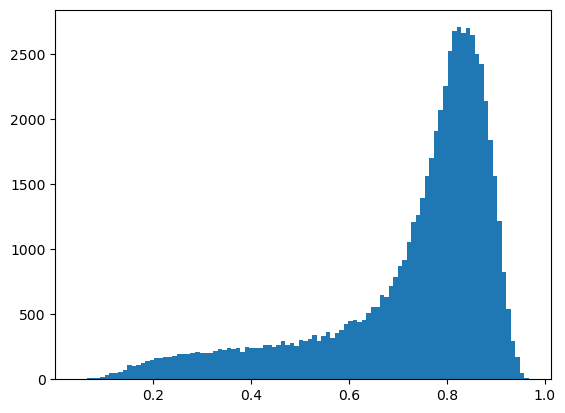

In [16]:
# We take a look at the sentiment distribution, it's skewed towards positive
plt.hist(sentiment, bins=100)
plt.show()

As we can see, the sentiment distribution is centered around 0.7-0.8 (0.0-0.5 indicates negative sentiment, and 0.5-1.0 indicates positive sentiment), and shapes like a normal distribution. We take a qualitative inspection on the model's predictions. 

In [17]:
# We sort the tweets according to its sentiment score
sorted_tweets = [x for _, x in sorted(zip(sentiment, eng_text_lst))]
sorted_sentiment = [x for x, _ in sorted(zip(sentiment, eng_text_lst))]

In [18]:
# We print out the top 10 most negative tweets and their sentiment
for _ in range(0,10):
    print("Tweet: {}".format(sorted_tweets[_]))
    print("Sentiment Score: {}".format(sorted_sentiment[_]))
    print("-------------------------------------------")

Tweet: An alliance of Egyptian islamist groups has canceled a series of public events due to fears of being attacked.... 
Sentiment Score: 0.04701407
-------------------------------------------
Tweet: Four people were missing and three bridges had collapsed in southwest China's Sichuan Province as of Tuesday... 
Sentiment Score: 0.05659788
-------------------------------------------
Tweet: Russian Space Agency reported that it has lost its Progress cargo spaceship that was to deliver 2.6 tons of supplies to the @Space_Station
Sentiment Score: 0.06748822
-------------------------------------------
Tweet: A doctor was killed and two others injured at a hospital in east China's Zhejiang Province on Friday.

Dr. Wang... 
Sentiment Score: 0.06792552
-------------------------------------------
Tweet: An #Iran passenger plane crashed into barrier at #Istanbul airport Thur. in #Turkey, crashing on a bus.
Sentiment Score: 0.069881156
-------------------------------------------
Tweet: A small pl

In [19]:
# We print out the top 10 most positive tweets and their sentiment
for _ in range(1,11):
    print("Tweet: {}".format(sorted_tweets[-_]))
    print("Sentiment Score: {}".format(sorted_sentiment[-_]))
    print("-------------------------------------------")

Tweet: Follow us on our special reports #YangtzeRiverStories, providing you with panoramic view of breathtaking scenery, rich eco-system, fascinating history and thriving economy of China's longest river-the Yangtze River.
Sentiment Score: 0.96715945
-------------------------------------------
Tweet: .@realDonaldTrump thanked President #XiJinping for "such an incredible welcome ceremony" held in Beijing Thursday morning, calling it "truly memorable and impressive"
Sentiment Score: 0.96497816
-------------------------------------------
Tweet: Chinese Premier Li Keqiang is welcomed by Pakistani President Asif Ali Zardari and interim Prime Minister Mir... 
Sentiment Score: 0.96453667
-------------------------------------------
Tweet: Chinese President #XiJinping delivers keynote speech at #CPC in Dialogue with World Political Parties High-level Meeting, whose theme is "Working together towards a community with a shared future for mankind and a better world: Responsibilities of political p

## Using an off-the-shelf model
Our model appears to have grasped the sentiment analysis task. However, there's a notable bias in its predictions, skewing heavily towards positive outcomes. While we could employ additional techniques to rectify this imbalance, it would lead us into the complex realm of deep learning. To maintain focus, we will opt for a pre-trained and calibrated off-the-shelf model for our analysis.

In [20]:
# this is the model we use for sentiment analysis, check out the datils of the model here: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
model_name_or_path = "cardiffnlp/twitter-roberta-base-sentiment"

# Use the default model configuration of BERT-base-cased
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=3,
    finetuning_task="text-classification",
)
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    use_fast=True,
)
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    from_tf=bool(".ckpt" in model_name_or_path),
    config=config,
)

In [21]:
model = model.to(device)
# Iterate over all tweets and do inference
sentiment_lst = []
for text in eng_text_lst:
    input_ids = tokenizer(text, padding=padding, max_length=max_seq_length, truncation=True)
    input_ids = torch.tensor(input_ids['input_ids']).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=None)
        pred = outputs.logits.detach()
        # Convert log-softmax scores to softmax scores
        softmax_probs = torch.exp(pred)
        # Normalize to get valid probabilities
        softmax_probs = softmax_probs / softmax_probs.sum(dim=1, keepdim=True)
        softmax_probs = softmax_probs.cpu().numpy()
    # Append the probability of being positive
    sentiment_lst.append(-softmax_probs[0,0]  + softmax_probs[0,2]) # Negative + Positive

In [22]:
# Save the results
df['sentiment'] = sentiment_lst
df.to_csv("../data/tweets_PDChina_All_with_sentiment_v2.csv", sep=',', index=False, encoding='utf-8')

In [23]:
# Load Saved DataFrame
df = pd.read_csv("../data/tweets_PDChina_All_with_sentiment_v2.csv")
sentiment = df['sentiment'].to_list()
sentiment = [x for x in sentiment]

Like what we have done before, we check to see the prediction distribution of the model, and conduct a qualitative analysis on its results.

In [24]:
# examine the min and max of the sentiment scores
min(sentiment), max(sentiment)

(-0.90233, 0.97077364)

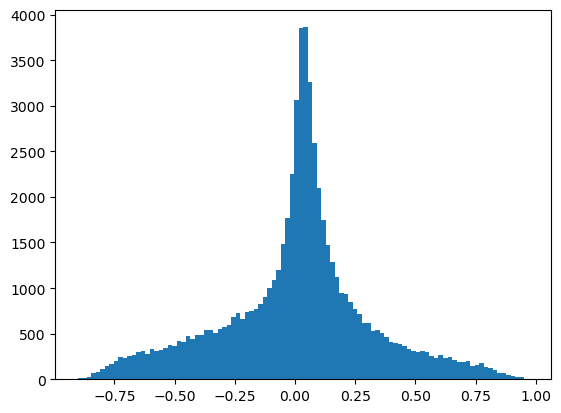

In [25]:
# We take a look at the sentiment distribution, it's skewed towards positive
plt.hist(sentiment, bins=100)
plt.show() 

In [26]:
# We sort the tweets according to its sentiment score
sorted_tweets = [x for _, x in sorted(zip(sentiment, eng_text_lst))]
sorted_sentiment = [x for x, _ in sorted(zip(sentiment, eng_text_lst))]

In [27]:
# We print out the top 10 most negative tweets and their sentiment
for _ in range(0,10):
    print("Tweet: {}".format(sorted_tweets[_]))
    print("Sentiment Score: {}".format(sorted_sentiment[_]))
    print("-------------------------------------------")

Tweet: 10 critically endangered black rhinos have died after being moved to a new habitat in Kenya, and the sole survivor in the transfer was injured after being attacked by a lion, sparking outrage over officials' negligence that led to what some have called a disaster for the species
Sentiment Score: -0.90233
-------------------------------------------
Tweet: Horrifying! An inflatable bouncy castle got thrown over by strong wind on the street of Quanzhou, SE China's Fujian province on Tuesday, killing a 6-year-old boy and leaving another two passers-by injured
Sentiment Score: -0.9013829
-------------------------------------------
Tweet: Extremely dangerous! Driver kills time by shooting slingshot to vehicles in #Beijing. Case is under investigation
Sentiment Score: -0.90084463
-------------------------------------------
Tweet: Jealous of the rich, drunkards vent hatred by damaging over 20 cars in E. China 
Sentiment Score: -0.89656323
-------------------------------------------
Twee

In [28]:
# We print out the top 10 most positive tweets and their sentiment
for _ in range(1,11):
    print("Tweet: {}".format(sorted_tweets[-_]))
    print("Sentiment Score: {}".format(sorted_sentiment[-_]))
    print("-------------------------------------------")

Tweet: A very happy birthday indeed! Female giant panda twins "Hehe" and "Jiujiu" on Friday celebrated their 3rd birthday in a comfortable air-conditioned room at the Nanjing Hongshan Forest Zoo in Nanjing, East China's Jiangsu Province. (Photo/Xinhua)
Sentiment Score: 0.97077364
-------------------------------------------
Tweet: It's that time of year again when we celebrate everything dad has done for us on the coming#FathersDayon Jun 17. We found some adorable animal-human embraces pulled by worldwide photographers, as animals were having heartwarming moments with their human dads. (Photo/IC)
Sentiment Score: 0.9563161
-------------------------------------------
Tweet: We're growing up! 23 giant #panda cubs born in Chengdu last yr regroup for the cutest-ever Spring Festival greeting: HAPPY #ChineseNewYear!
Sentiment Score: 0.9544175
-------------------------------------------
Tweet: Happy birthday to you! Male panda Jiao Qing celebrated his 8th birthday with a three-story birthday c